In [2]:
import numpy as np
import path as Path
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.axes as ax
from matplotlib.pyplot import figure
from IPython.display import Image
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatwCDM
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
from astropy.cosmology import wCDM
from astropy.cosmology import Flatw0waCDM
import scipy
import pdb
from escape_functions_noastropy import *
from scipy.interpolate import interp1d
from scipy.stats import linregress

In [3]:
cosmo = FlatwCDM(H0=70, Om0=0.2,w0=-1)
cosmo = wCDM(H0=70, Om0=0.2,Ode0 = 0.8,w0=-1)
cosmo = FlatLambdaCDM(H0=70,Om0=0.2)
cosmo = LambdaCDM(H0=70, Om0=0.2, Ode0 = 0)
cosmo = Flatw0waCDM(H0=70, Om0=0.2, w0=-0.9, wa=0.2)

In [4]:
def cosmology(cosmology):
    case = cosmology.name
    if case == 'Flatw0waCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.wa, cosmology.h]
    
    elif case == 'FlatwCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.h]

    elif case == 'wCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.w0,cosmology.h]
        
    elif case == 'LambdaCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.h]

    elif case == 'FlatLambdaCDM':
        return [cosmology.Om0, cosmology.h]

### Files

In [5]:
front_part = '/nfs/Christoq1/pvans/MiraTitan/halo/sort/M000/halopart/'
front_halo = '/nfs/Christoq1/pvans/MiraTitan/FOF/M000_good/'
front_results = '/nfs/Christoq1/MiraTitanU_analysis/density_fits/results_pvans_M0/'

In [6]:
rad_file_0 = fits.open(front_results + 'phi_ein/r_vescmax.fits')
rad_0 = rad_file_0[0].data
m_edge_file_0 = fits.open(front_results + 'phi_ein/v_at_vescmax5.fits')
m_edge_0 = m_edge_file_0[0].data
dens_fit = fits.open(front_results + 'dens_ein/dens_fit.fits')
dt = [('HaloId',int), ('n',float), ('n_err',float),('rho_0',float),('rho_o_err',float),
          ('h',float),('h_err',float),('norm_ein',float)]
einasto_prof_0 =  np.loadtxt(front_results + 'dens_ein/ds_ein_concentrations.dat', dtype=dt,skiprows=0) 

In [7]:
rad_file_0_gam = fits.open(front_results + 'phi_gam/r_vescmax.fits')
rad_0_gam = rad_file_0_gam[0].data
m_edge_file_0_gam = fits.open(front_results + 'phi_gam/v_at_vescmax5.fits')
m_edge_0_gam = m_edge_file_0_gam[0].data
dens_fit_gam = fits.open(front_results + 'dens_gam/dens_fit.fits')
dt2 = [('HaloId', int),('gamma',float),('gamma_err',float),('mass0',float),('mass0_err',float),('r_s',float),('rs_err',float)]
dehnen_prof_0 =  np.loadtxt(front_results + 'dens_gam/ds_gam_concentrations.dat', dtype=dt2,skiprows=0) 

In [8]:
dt = [('HaloId', np.float64),('m200crit',np.float64),('px',float),('py',float),('pz',float),('vx',float),('vy',float),('vz',float)]
filename_0 =  front_halo + 'z00_good.txt'
cluster_list_0 =  np.loadtxt(filename_0, dtype=dt,skiprows=0)
filename_z02 =  front_halo + 'z02_good.txt'
cluster_list_z02 =  np.loadtxt(filename_z02, dtype=dt,skiprows=0)
filename_z04 =  front_halo + 'z04_good.txt'
cluster_list_z04 =  np.loadtxt(filename_z04, dtype=dt,skiprows=0)
filename_z06 =  front_halo + 'z06_good.txt'
cluster_list_z06 =  np.loadtxt(filename_z06, dtype=dt,skiprows=0)

### M000

In [9]:
cosmo_name = 'FlatLambdaCDM'
cosmo = FlatLambdaCDM(H0=71,Om0=0.26479, name = cosmo_name)
cosmo_params = cosmology(cosmo)

In [10]:
z=0.0001
h_0 = 0.71
#mass = np.hstack((cluster_list_0['m200crit'], cluster_list_0_e['m200crit']))
mass = cluster_list_0['m200crit']
hmass = mass/h_0
#print (hmass)
M200 = hmass*u.solMass
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
print ('Astropys critical density: ', rho_crit)
print ('Internal critical density: ',rho_crit_z(z,cosmo_params,'FlatLambdaCDM'))
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
theta_array = radius_array /cosmo.angular_diameter_distance(z)
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
#print ('Spherical R200 for a given M200: ', R200crit)
G_newton = astroc.G.to( u.Mpc *  u.km**2 / u.s**2 / u.solMass).value #Mpc km2/s^2 kg

Astropys critical density:  139917328634.8423 solMass / Mpc3
Internal critical density:  139917328634.8423 solMass / Mpc3


In [11]:
z_0 = np.array((0.0001))
z_0 = np.repeat(z_0,(251))
num_clus = len(z_0)
M200_orig = np.repeat(hmass,len(z_0))
M200_use = np.repeat(hmass,(1))
R200 =  ((3*M200)/(4*np.pi*200.* rho_crit))**(1./3.)
N = np.repeat(1000000,len(z_0))

rho_0_list = einasto_prof_0['rho_0']
h_list = einasto_prof_0['h']
n_list = einasto_prof_0['n']
rho_0 = np.repeat(rho_0_list, (1))
h = np.repeat(h_list, (1))
n = np.repeat(n_list, (1))

gamma_list = dehnen_prof_0['gamma']
mass0_list = dehnen_prof_0['mass0']
r_s_list = dehnen_prof_0['r_s']
gamma = np.repeat(gamma_list, (1))
mass_0 = np.repeat(mass0_list, (1))
r_s = np.repeat(r_s_list, (1))

radius_array = rad_0_gam #specify radius array for profiles. used in v_esc(r) funcs below.
#print (len(rad_0_gam))
radial_bins = 80
xdata = np.zeros((len(z_0),radial_bins))
for i in range(len(z_0)):
    #print (radius_array[i,:])
    xdata[i,:] = radius_array[i,:] /D_A(z_0[i], cosmo_params, cosmo.name).value
    #print (xdata[i,:])
r_M0_DEH,vesc_M0_DEH = v_esc_dehnen(xdata,z_0,mass_0,r_s,gamma,N, cosmo_params, cosmo_name, num_clus)
r_M0_EIN,vesc_M0_EIN = v_esc_einasto(xdata,z_0,rho_0,h,n,N, cosmo_params, cosmo_name, num_clus)
r_M0_NFW,vesc_M0_NFW = v_esc_NFW_M200(xdata,z_0,M200_use,N, cosmo_params, cosmo_name, num_clus)

In [12]:
perc_diff_M0 = []
median_perc_diff_M0 = []
median_high_M0 = []
median_low_M0 = []

for j in range(len(z_0)):
    pd_0 = (vesc_M0_EIN[j,:]-m_edge_0[j,:])/m_edge_0[j,:]
    perc_diff_M0.append(pd_0)
    
perc_diff_arr_M0 = np.array(perc_diff_M0)

for m in range(80):
    median = np.percentile(perc_diff_arr_M0[:,m],50)
    median_perc_diff_M0.append(median)
    median_high = np.percentile(perc_diff_arr_M0[:,m],83.5)
    median_high_M0.append(median_high)
    median_low = np.percentile(perc_diff_arr_M0[:,m],16.5)
    median_low_M0.append(median_low)

<ipython-input-12-581c09eb5d66>:7: RuntimeWarning: divide by zero encountered in true_divide
  pd_0 = (vesc_M0_EIN[j,:]-m_edge_0[j,:])/m_edge_0[j,:]
/u/home/pvans/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


### M001

In [13]:
front_part_M1 = '/nfs/Christoq1/pvans/MiraTitan/halo/sort/M001/halopart/'
front_halo_M1 = '/nfs/Christoq1/pvans/MiraTitan/FOF/M001_good/'
front_results_M1 = '/nfs/Christoq1/MiraTitanU_analysis/density_fits/results_pvans_M1/'
front_part_z02 = '/nfs/Christoq1/pvans/MiraTitan/halo/sort/M1z02/halopart/'
front_part_z04 = '/nfs/Christoq1/pvans/MiraTitan/halo/sort/M1z04/halopart/'
front_part_z06 = '/nfs/Christoq1/pvans/MiraTitan/halo/sort/M1z06/halopart/'
front_halo = '/nfs/Christoq1/pvans/MiraTitan/FOF/M001_good/'
front_ein_z02 = '/nfs/Christoq1/MiraTitanU_analysis/density_fits/results_pvans_M1/z02/'
front_ein_z04 = '/nfs/Christoq1/MiraTitanU_analysis/density_fits/results_pvans_M1/z04/'
front_ein_z06 = '/nfs/Christoq1/MiraTitanU_analysis/density_fits/results_pvans_M1/z06/'

In [14]:
#M001 Cosmology
cosmo_name = 'Flatw0waCDM'
cosmo = Flatw0waCDM(H0=61.67, Om0=0.38705, w0=-0.7, wa=0.6722, name = cosmo_name)
cosmo_params = cosmology(cosmo)

In [15]:
z=0.0001
h_0 = 0.6167
#mass = np.hstack((cluster_list_0['m200crit'], cluster_list_0_e['m200crit']))
mass = cluster_list_0['m200crit']
hmass = mass/h_0
#print (hmass)
M200 = hmass*u.solMass
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
print ('Astropys critical density: ', rho_crit)
print ('Internal critical density: ',rho_crit_z(z,cosmo_params,'Flatw0waCDM'))
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
theta_array = radius_array /cosmo.angular_diameter_distance(z)
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
#print ('Spherical R200 for a given M200: ', R200crit)
G_newton = astroc.G.to( u.Mpc *  u.km**2 / u.s**2 / u.solMass).value #Mpc km2/s^2 kg

Astropys critical density:  105570502928.1437 solMass / Mpc3
Internal critical density:  105570502928.14365 solMass / Mpc3


In [16]:
z_0 = np.array((0.0001))
z_0 = np.repeat(z_0,(251))
num_clus = len(z_0)
M200_orig = np.repeat(hmass,len(z_0))
M200_use = np.repeat(hmass,(1))
R200 =  ((3*M200)/(4*np.pi*200.* rho_crit))**(1./3.)
N = np.repeat(1000000,len(z_0))

rho_0_list = einasto_prof_0['rho_0']
h_list = einasto_prof_0['h']
n_list = einasto_prof_0['n']
rho_0 = np.repeat(rho_0_list, (1))
h = np.repeat(h_list, (1))
n = np.repeat(n_list, (1))

gamma_list = dehnen_prof_0['gamma']
mass0_list = dehnen_prof_0['mass0']
r_s_list = dehnen_prof_0['r_s']
gamma = np.repeat(gamma_list, (1))
mass_0 = np.repeat(mass0_list, (1))
r_s = np.repeat(r_s_list, (1))

radius_array = rad_0_gam #specify radius array for profiles. used in v_esc(r) funcs below.
#print (len(rad_0_gam))
radial_bins = 80
xdata = np.zeros((len(z_0),radial_bins))
for i in range(len(z_0)):
    #print (radius_array[i,:])
    xdata[i,:] = radius_array[i,:] /D_A(z_0[i], cosmo_params, cosmo.name).value
    #print (xdata[i,:])
r_M1_DEH,vesc_M1_DEH = v_esc_dehnen(xdata,z_0,mass_0,r_s,gamma,N, cosmo_params, cosmo_name, num_clus)
r_M1_EIN,vesc_M1_EIN = v_esc_einasto(xdata,z_0,rho_0,h,n,N, cosmo_params, cosmo_name, num_clus)
r_M1_NFW,vesc_M1_NFW = v_esc_NFW_M200(xdata,z_0,M200_use,N, cosmo_params, cosmo_name, num_clus)

### M005

In [17]:
#M005 Cosmology
cosmo_name = 'Flatw0waCDM'
cosmo = Flatw0waCDM(H0=85,Om0=0.19832, w0=-1.2330 , wa=0.0445, name = cosmo_name)
cosmo_params = cosmology(cosmo)

In [18]:
z=0.0001
h_0 = 0.85
#mass = np.hstack((cluster_list_0['m200crit'], cluster_list_0_e['m200crit']))
mass = cluster_list_0['m200crit']
hmass = mass/h_0
#print (hmass)
M200 = hmass*u.solMass
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
print ('Astropys critical density: ', rho_crit)
print ('Internal critical density: ',rho_crit_z(z,cosmo_params,'Flatw0waCDM'))
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
theta_array = radius_array /cosmo.angular_diameter_distance(z)
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
#print ('Spherical R200 for a given M200: ', R200crit)
G_newton = astroc.G.to( u.Mpc *  u.km**2 / u.s**2 / u.solMass).value #Mpc km2/s^2 kg

Astropys critical density:  200520908951.1366 solMass / Mpc3
Internal critical density:  200520908951.1366 solMass / Mpc3


In [19]:
z_0 = np.array((0.0001))
z_0 = np.repeat(z_0,(251))
num_clus = len(z_0)
M200_orig = np.repeat(hmass,len(z_0))
M200_use = np.repeat(hmass,(1))
R200 =  ((3*M200)/(4*np.pi*200.* rho_crit))**(1./3.)
N = np.repeat(1000000,len(z_0))

rho_0_list = einasto_prof_0['rho_0']
h_list = einasto_prof_0['h']
n_list = einasto_prof_0['n']
rho_0 = np.repeat(rho_0_list, (1))
h = np.repeat(h_list, (1))
n = np.repeat(n_list, (1))

gamma_list = dehnen_prof_0['gamma']
mass0_list = dehnen_prof_0['mass0']
r_s_list = dehnen_prof_0['r_s']
gamma = np.repeat(gamma_list, (1))
mass_0 = np.repeat(mass0_list, (1))
r_s = np.repeat(r_s_list, (1))

radius_array = rad_0_gam #specify radius array for profiles. used in v_esc(r) funcs below.
#print (len(rad_0_gam))
radial_bins = 80
xdata = np.zeros((len(z_0),radial_bins))
for i in range(len(z_0)):
    #print (radius_array[i,:])
    xdata[i,:] = radius_array[i,:] /D_A(z_0[i], cosmo_params, cosmo.name).value
    #print (xdata[i,:])
r_M5_DEH,vesc_M5_DEH = v_esc_dehnen(xdata,z_0,mass_0,r_s,gamma,N, cosmo_params, cosmo_name, num_clus)
r_M5_EIN,vesc_M5_EIN = v_esc_einasto(xdata,z_0,rho_0,h,n,N, cosmo_params, cosmo_name, num_clus)
r_M5_NFW,vesc_M5_NFW = v_esc_NFW_M200(xdata,z_0,M200_use,N, cosmo_params, cosmo_name, num_clus)

/nfs/Christoq1/pvans/MiraTitan/analysis_notebooks/escapevelocitycosmology/escape_functions_noastropy.py:77: RuntimeWarning: invalid value encountered in sqrt
  v_esc = (-2.*phi_dehnen(r,mass_0[i],r_s[i],gamma[i])+2.*phi_dehnen(req,mass_0[i],r_s[i],gamma[i]) - q_z*(H_z**2.)*(r**2. - req**2.)  )**0.5
/nfs/Christoq1/pvans/MiraTitan/analysis_notebooks/escapevelocitycosmology/escape_functions_noastropy.py:128: RuntimeWarning: invalid value encountered in sqrt
  v_esc =  (-2.*phi_einasto(r,rho_0[i],h[i],n[i])+2.*phi_einasto(req,rho_0[i],h[i],n[i]) - q_z*(H_z**2.)*(r**2. - req**2.)  )**0.5
/nfs/Christoq1/pvans/MiraTitan/analysis_notebooks/escapevelocitycosmology/escape_functions_noastropy.py:191: RuntimeWarning: invalid value encountered in sqrt
  v_esc = (-2.*phi_nfw(r,rho_s,r_s) +2*phi_nfw(req,rho_s,r_s)-q_z*(H_z**2.)*(r**2 - req**2) )**0.5


### M006

In [20]:
#M006 cosmo
cosmo_name = 'Flatw0waCDM'
cosmo = Flatw0waCDM(H0=55,Om0=0.43537, w0=-0.7667 , wa=0.1944, name = cosmo_name)
cosmo_params = cosmology(cosmo)

In [21]:
z=0.0001
h_0 = 0.55
#mass = np.hstack((cluster_list_0['m200crit'], cluster_list_0_e['m200crit']))
mass = cluster_list_0['m200crit']
hmass = mass/h_0
#print (hmass)
M200 = hmass*u.solMass
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
print ('Astropys critical density: ', rho_crit)
print ('Internal critical density: ',rho_crit_z(z,cosmo_params,'Flatw0waCDM'))
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
theta_array = radius_array /cosmo.angular_diameter_distance(z)
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
#print ('Spherical R200 for a given M200: ', R200crit)
G_newton = astroc.G.to( u.Mpc *  u.km**2 / u.s**2 / u.solMass).value #Mpc km2/s^2 kg

Astropys critical density:  83969114115.54305 solMass / Mpc3
Internal critical density:  83969114115.54306 solMass / Mpc3


In [22]:
z_0 = np.array((0.0001))
z_0 = np.repeat(z_0,(251))
num_clus = len(z_0)
M200_orig = np.repeat(hmass,len(z_0))
M200_use = np.repeat(hmass,(1))
R200 =  ((3*M200)/(4*np.pi*200.* rho_crit))**(1./3.)
N = np.repeat(1000000,len(z_0))

rho_0_list = einasto_prof_0['rho_0']
h_list = einasto_prof_0['h']
n_list = einasto_prof_0['n']
rho_0 = np.repeat(rho_0_list, (1))
h = np.repeat(h_list, (1))
n = np.repeat(n_list, (1))

gamma_list = dehnen_prof_0['gamma']
mass0_list = dehnen_prof_0['mass0']
r_s_list = dehnen_prof_0['r_s']
gamma = np.repeat(gamma_list, (1))
mass_0 = np.repeat(mass0_list, (1))
r_s = np.repeat(r_s_list, (1))

radius_array = rad_0_gam #specify radius array for profiles. used in v_esc(r) funcs below.
#print (len(rad_0_gam))
radial_bins = 80
xdata = np.zeros((len(z_0),radial_bins))
for i in range(len(z_0)):
    #print (radius_array[i,:])
    xdata[i,:] = radius_array[i,:] /D_A(z_0[i], cosmo_params, cosmo.name).value
    #print (xdata[i,:])
r_M6_DEH,vesc_M6_DEH = v_esc_dehnen(xdata,z_0,mass_0,r_s,gamma,N, cosmo_params, cosmo_name, num_clus)
r_M6_EIN,vesc_M6_EIN = v_esc_einasto(xdata,z_0,rho_0,h,n,N, cosmo_params, cosmo_name, num_clus)
r_M6_NFW,vesc_M6_NFW = v_esc_NFW_M200(xdata,z_0,M200_use,N, cosmo_params, cosmo_name, num_clus)

### M010

In [23]:
cosmo_name = 'Flatw0waCDM'
cosmo = Flatw0waCDM(H0=78.33, Om0=0.18553, w0=-1.3, wa=-0.5222, name = cosmo_name)
cosmo_params = cosmology(cosmo)

In [24]:
z=0.0001
h_0 = 0.7833
#mass = np.hstack((cluster_list_0['m200crit'], cluster_list_0_e['m200crit']))
mass = cluster_list_0['m200crit']
hmass = mass/h_0
#print (hmass)
M200 = hmass*u.solMass
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
print ('Astropys critical density: ', rho_crit)
print ('Internal critical density: ',rho_crit_z(z,cosmo_params,'Flatw0waCDM'))
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
theta_array = radius_array /cosmo.angular_diameter_distance(z)
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
#print ('Spherical R200 for a given M200: ', R200crit)
G_newton = astroc.G.to( u.Mpc *  u.km**2 / u.s**2 / u.solMass).value #Mpc km2/s^2 kg

Astropys critical density:  170282061602.8666 solMass / Mpc3
Internal critical density:  170282061602.86655 solMass / Mpc3


In [25]:
z_0 = np.array((0.0001))
z_0 = np.repeat(z_0,(251))
num_clus = len(z_0)
M200_orig = np.repeat(hmass,len(z_0))
M200_use = np.repeat(hmass,(1))
R200 =  ((3*M200)/(4*np.pi*200.* rho_crit))**(1./3.)
N = np.repeat(1000000,len(z_0))

rho_0_list = einasto_prof_0['rho_0']
h_list = einasto_prof_0['h']
n_list = einasto_prof_0['n']
rho_0 = np.repeat(rho_0_list, (1))
h = np.repeat(h_list, (1))
n = np.repeat(n_list, (1))

gamma_list = dehnen_prof_0['gamma']
mass0_list = dehnen_prof_0['mass0']
r_s_list = dehnen_prof_0['r_s']
gamma = np.repeat(gamma_list, (1))
mass_0 = np.repeat(mass0_list, (1))
r_s = np.repeat(r_s_list, (1))

radius_array = rad_0_gam #specify radius array for profiles. used in v_esc(r) funcs below.
#print (len(rad_0_gam))
radial_bins = 80
xdata = np.zeros((len(z_0),radial_bins))
for i in range(len(z_0)):
    #print (radius_array[i,:])
    xdata[i,:] = radius_array[i,:] /D_A(z_0[i], cosmo_params, cosmo.name).value
    #print (xdata[i,:])
r_M10_DEH,vesc_M10_DEH = v_esc_dehnen(xdata,z_0,mass_0,r_s,gamma,N, cosmo_params, cosmo_name, num_clus)
r_M10_EIN,vesc_M10_EIN = v_esc_einasto(xdata,z_0,rho_0,h,n,N, cosmo_params, cosmo_name, num_clus)
r_M10_NFW,vesc_M10_NFW = v_esc_NFW_M200(xdata,z_0,M200_use,N, cosmo_params, cosmo_name, num_clus)

### Comparisons

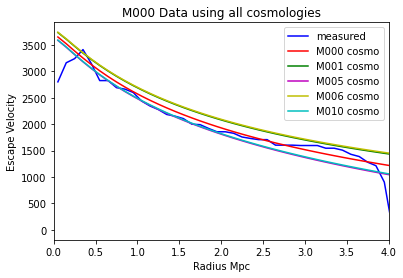

In [26]:
j=22
plt.plot(rad_0[j,:], m_edge_0[j,:], color = 'b', label = 'measured')
plt.plot(rad_0[j,:], vesc_M0_EIN[j,:], color = 'r', label = 'M000 cosmo')
plt.plot(rad_0[j,:], vesc_M1_EIN[j,:], color = 'g', label = 'M001 cosmo')
plt.plot(rad_0[j,:], vesc_M5_EIN[j,:], color = 'm', label = 'M005 cosmo')
plt.plot(rad_0[j,:], vesc_M6_EIN[j,:], color = 'y', label = 'M006 cosmo')
plt.plot(rad_0[j,:], vesc_M10_EIN[j,:], color = 'c', label = 'M010 cosmo')

plt.title('M000 Data using all cosmologies')
plt.xlim(0,4)
plt.xlabel('Radius Mpc')
plt.ylabel('Escape Velocity')
plt.savefig('M000-cosmo-comp-einasto.png', dpi = 200)
plt.legend()
plt.show()

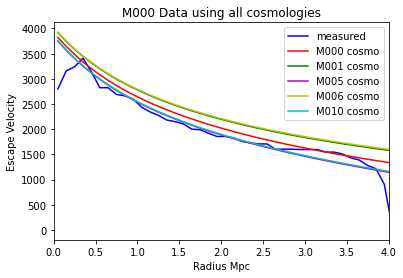

In [27]:
j=22
plt.plot(rad_0[j,:], m_edge_0[j,:], color = 'b', label = 'measured')
plt.plot(rad_0[j,:], vesc_M0_DEH[j,:], color = 'r', label = 'M000 cosmo')
plt.plot(rad_0[j,:], vesc_M1_DEH[j,:], color = 'g', label = 'M001 cosmo')
plt.plot(rad_0[j,:], vesc_M5_DEH[j,:], color = 'm', label = 'M005 cosmo')
plt.plot(rad_0[j,:], vesc_M6_DEH[j,:], color = 'y', label = 'M006 cosmo')
plt.plot(rad_0[j,:], vesc_M10_DEH[j,:], color = 'c', label = 'M010 cosmo')

plt.title('M000 Data using all cosmologies')
plt.xlim(0,4)
plt.xlabel('Radius Mpc')
plt.ylabel('Escape Velocity')
plt.savefig('M000-cosmo-comp-dehnen.png', dpi = 200)
plt.legend()
plt.show()

# Redshift Trends

In [28]:
front_results = '/nfs/Christoq1/MiraTitanU_analysis/density_fits/'

m_edge_file_0 = fits.open(front_results + 'results_pvans_M0/phi_ein/v_at_vescmax5.fits')
M0z0_edge = m_edge_file_0[0].data
m_edge_file_m0z2 = fits.open(front_results + 'results_pvans_M0/z02/phi_ein/v_at_vescmax5.fits')
M0z02_edge = m_edge_file_m0z2[0].data
m_edge_file_m0z4 = fits.open(front_results + 'results_pvans_M0/z04/phi_ein/v_at_vescmax5.fits')
M0z04_edge = m_edge_file_m0z4[0].data
m_edge_file_m0z4 = fits.open(front_results + 'results_pvans_M0/z04/phi_ein/v_at_vescmax5.fits')
M0z04_edge = m_edge_file_m0z4[0].data
m_edge_file_m0z6 = fits.open(front_results + 'results_pvans_M0/z06/phi_ein/v_at_vescmax5.fits')
M0z06_edge = m_edge_file_m0z6[0].data

m_edge_file_1 = fits.open(front_results + 'results_pvans_M1/phi_ein/v_at_vescmax5.fits')
M1z0_edge = m_edge_file_1[0].data
m_edge_file_m1z2 = fits.open(front_results + 'results_pvans_M1/z02/phi_ein/v_at_vescmax5.fits')
M1z02_edge = m_edge_file_m1z2[0].data
m_edge_file_m1z4 = fits.open(front_results + 'results_pvans_M1/z04/phi_ein/v_at_vescmax5.fits')
M1z04_edge = m_edge_file_m1z4[0].data
m_edge_file_m1z6 = fits.open(front_results + 'results_pvans_M1/z06/phi_ein/v_at_vescmax5.fits')
M1z06_edge = m_edge_file_m1z6[0].data

m_edge_file_5 = fits.open(front_results + 'results_pvans_M5/phi_ein/v_at_vescmax5.fits')
M5z0_edge = m_edge_file_5[0].data
m_edge_file_m5z2 = fits.open(front_results + 'results_pvans_M5/z02/phi_ein/v_at_vescmax5.fits')
M5z02_edge = m_edge_file_m5z2[0].data
m_edge_file_m5z4 = fits.open(front_results + 'results_pvans_M5/z04/phi_ein/v_at_vescmax5.fits')
M5z04_edge = m_edge_file_m5z4[0].data
m_edge_file_m5z6 = fits.open(front_results + 'results_pvans_M5/z06/phi_ein/v_at_vescmax5.fits')
M5z06_edge = m_edge_file_m5z6[0].data

m_edge_file_6 = fits.open(front_results + 'results_pvans_M6/phi_ein/v_at_vescmax5.fits')
M6z0_edge = m_edge_file_6[0].data
m_edge_file_m6z2 = fits.open(front_results + 'results_pvans_M6/z02/phi_ein/v_at_vescmax5.fits')
M6z02_edge = m_edge_file_m6z2[0].data
m_edge_file_m6z4 = fits.open(front_results + 'results_pvans_M6/z04/phi_ein/v_at_vescmax5.fits')
M6z04_edge = m_edge_file_m6z4[0].data
m_edge_file_m6z6 = fits.open(front_results + 'results_pvans_M6/z06/phi_ein/v_at_vescmax5.fits')
M6z06_edge = m_edge_file_m6z6[0].data

m_edge_file_10 = fits.open(front_results + 'results_pvans_M10/phi_ein/v_at_vescmax5.fits')
M10z0_edge = m_edge_file_10[0].data
m_edge_file_m10z2 = fits.open(front_results + 'results_pvans_M10/z02/phi_ein/v_at_vescmax5.fits')
M10z02_edge = m_edge_file_m10z2[0].data
m_edge_file_m10z4 = fits.open(front_results + 'results_pvans_M10/z04/phi_ein/v_at_vescmax5.fits')
M10z04_edge = m_edge_file_m10z4[0].data
m_edge_file_m10z6 = fits.open(front_results + 'results_pvans_M10/z06/phi_ein/v_at_vescmax5.fits')
M10z06_edge = m_edge_file_m10z6[0].data

In [29]:
print (np.shape(M10z0_edge))

(221, 80)


In [30]:
vesc_M0z0 = np.loadtxt('vesc_ein_M0z0.txt')
vesc_M0z02 = np.loadtxt('vesc_ein_m0z02.txt')
vesc_M0z04 = np.loadtxt('vesc_ein_M0z04.txt')
vesc_M0z06 = np.loadtxt('vesc_ein_M0z06.txt')

vesc_M1z0 = np.loadtxt('vesc_ein_M1z0.txt')
vesc_M1z02 = np.loadtxt('vesc_ein_M1z02.txt')
vesc_M1z04 = np.loadtxt('vesc_ein_M1z04.txt')
vesc_M1z06 = np.loadtxt('vesc_ein_M1z06.txt')

vesc_M5z0 = np.loadtxt('vesc_ein_M5z0.txt')
vesc_M5z02 = np.loadtxt('vesc_ein_M5z02.txt')
vesc_M5z04 = np.loadtxt('vesc_ein_M5z04.txt')
vesc_M5z06 = np.loadtxt('vesc_ein_M5z06.txt')

vesc_M6z0 = np.loadtxt('vesc_ein_M6z0.txt')
vesc_M6z02 = np.loadtxt('vesc_ein_M6z02.txt')
vesc_M6z04 = np.loadtxt('vesc_ein_M6z04.txt')
vesc_M6z06 = np.loadtxt('vesc_ein_M6z06.txt')

vesc_M10z0 = np.loadtxt('vesc_ein_M10z0.txt')
vesc_M10z02 = np.loadtxt('vesc_ein_M10z02.txt')
vesc_M10z04 = np.loadtxt('vesc_ein_M10z04.txt')
vesc_M10z06 = np.loadtxt('vesc_ein_M10z06.txt')

In [31]:
print (len(vesc_M10z0))

221


In [32]:
z_0 = np.array((0.000001))
z_02 = np.array((0.212304))
z_04 = np.array((0.401674))
z_06 = np.array((0.618357))

M0z_0 = np.repeat(z_0,(251))
M1z_0 = np.repeat(z_0,(249))
M5z_0 = np.repeat(z_0,(248))
M6z_0 = np.repeat(z_0,(236))
M10z_0 = np.repeat(z_0,(221))

M0z_02 = np.repeat(z_02,(270))
M1z_02 = np.repeat(z_02,(266))
M5z_02 = np.repeat(z_02,(216))
M6z_02 = np.repeat(z_02,(231))
M10z_02 = np.repeat(z_02,(265))

M0z_04 = np.repeat(z_04,(246))
M1z_04 = np.repeat(z_04,(204))
M5z_04 = np.repeat(z_04,(240))
M6z_04 = np.repeat(z_04,(206))
M10z_04 = np.repeat(z_04,(211))

M0z_06 = np.repeat(z_06,(249))
M1z_06 = np.repeat(z_06,(203))
M5z_06 = np.repeat(z_06,(250))
M6z_06 = np.repeat(z_06,(250))
M10z_06 = np.repeat(z_06,(213))

In [33]:
#For M0
perc_diff_M0 = []
median_perc_diff_M0 = []
median_high_M0 = []
median_low_M0 = []
perc_diff_z02 = []
median_perc_diff_M0z02 = []
med_z02_low = []
med_z02_high = []
perc_diff_z04 = []
median_perc_diff_M0z04 = []
med_z04_low = []
med_z04_high = []
perc_diff_z06 = []
median_perc_diff_M0z06 = []
med_z06_low = []
med_z06_high = []

for i in range(len(M0z_0)):
    pd_0 = (vesc_M0z0[i,:]-M0z0_edge[i,:])/M0z0_edge[i,:]
    perc_diff_M0.append(pd_0)
for j in range(len(M0z_02)):
    pd_z02 = (vesc_M0z02[j,:]-M0z02_edge[j,:])/M0z02_edge[j,:]
    perc_diff_z02.append(pd_z02)
for k in range(len(M0z_04)):
    pd_z04 = (vesc_M0z04[k,:]-M0z04_edge[k,:])/M0z04_edge[k,:]
    perc_diff_z04.append(pd_z04)
for l in range(len(M0z_06)):
    pd_z06 = (vesc_M0z06[l,:]-M0z06_edge[l,:])/M0z06_edge[l,:]
    perc_diff_z06.append(pd_z06)
    
perc_diff_arr_M0 = np.array(perc_diff_M0)
perc_diff_arr_M0z02 = np.array(perc_diff_z02)
perc_diff_arr_M0z04 = np.array(perc_diff_z04)
perc_diff_arr_M0z06 = np.array(perc_diff_z06)

for m in range(80):
    median = np.percentile(perc_diff_arr_M0[:,m],50)
    median_perc_diff_M0.append(median)
    median_high = np.percentile(perc_diff_arr_M0[:,m],83.5)
    median_high_M0.append(median_high)
    median_low = np.percentile(perc_diff_arr_M0[:,m],16.5)
    median_low_M0.append(median_low)
    median_2 = np.percentile(perc_diff_arr_M0z02[:,m],50)
    median_perc_diff_M0z02.append(median_2)
    med_2_high = np.percentile(perc_diff_arr_M0z02[:,m],83.5)
    med_z02_high.append(med_2_high)
    med_2_low = np.percentile(perc_diff_arr_M0z02[:,m],16.5)
    med_z02_low.append(med_2_low)
    median_4 = np.percentile(perc_diff_arr_M0z04[:,m],50)
    median_perc_diff_M0z04.append(median_4)
    med_4_high = np.percentile(perc_diff_arr_M0z04[:,m],83.5)
    med_z04_high.append(med_4_high)
    med_4_low = np.percentile(perc_diff_arr_M0z04[:,m],16.5)
    med_z04_low.append(med_4_low)
    median_6 = np.percentile(perc_diff_arr_M0z06[:,m],50)
    median_perc_diff_M0z06.append(median_6)
    med_6_high = np.percentile(perc_diff_arr_M0z06[:,m],83.5)
    med_z06_high.append(med_6_high)
    med_6_low = np.percentile(perc_diff_arr_M0z06[:,m],16.5)
    med_z06_low.append(med_6_low)

<ipython-input-33-ed6c549eb5bd>:20: RuntimeWarning: divide by zero encountered in true_divide
  pd_0 = (vesc_M0z0[i,:]-M0z0_edge[i,:])/M0z0_edge[i,:]
<ipython-input-33-ed6c549eb5bd>:23: RuntimeWarning: divide by zero encountered in true_divide
  pd_z02 = (vesc_M0z02[j,:]-M0z02_edge[j,:])/M0z02_edge[j,:]
<ipython-input-33-ed6c549eb5bd>:26: RuntimeWarning: divide by zero encountered in true_divide
  pd_z04 = (vesc_M0z04[k,:]-M0z04_edge[k,:])/M0z04_edge[k,:]
<ipython-input-33-ed6c549eb5bd>:29: RuntimeWarning: divide by zero encountered in true_divide
  pd_z06 = (vesc_M0z06[l,:]-M0z06_edge[l,:])/M0z06_edge[l,:]
/u/home/pvans/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


In [34]:
#For M1
perc_diff_M1 = []
median_perc_diff_M1 = []
median_high_M1 = []
median_low_M1 = []
perc_diff_M1z02 = []
median_perc_diff_M1z02 = []
med_M1z02_low = []
med_M1z02_high = []
perc_diff_M1z04 = []
median_perc_diff_M1z04 = []
med_M1z04_low = []
med_M1z04_high = []
perc_diff_M1z06 = []
median_perc_diff_M1z06 = []
med_M1z06_low = []
med_M1z06_high = []

for i in range(len(M1z_0)):
    pd_0 = (vesc_M1z0[i,:]-M1z0_edge[i,:])/M1z0_edge[i,:]
    perc_diff_M1.append(pd_0)
for j in range(len(M1z_02)):
    pd_z02 = (vesc_M1z02[j,:]-M1z02_edge[j,:])/M1z02_edge[j,:]
    perc_diff_M1z02.append(pd_z02)
for k in range(len(M1z_04)):
    pd_z04 = (vesc_M1z04[k,:]-M1z04_edge[k,:])/M1z04_edge[k,:]
    perc_diff_M1z04.append(pd_z04)
for l in range(len(M1z_06)):
    pd_z06 = (vesc_M1z06[l,:]-M1z06_edge[l,:])/M1z06_edge[l,:]
    perc_diff_M1z06.append(pd_z06)
    
perc_diff_arr_M1 = np.array(perc_diff_M1)
perc_diff_arr_M1z02 = np.array(perc_diff_M1z02)
perc_diff_arr_M1z04 = np.array(perc_diff_M1z04)
perc_diff_arr_M1z06 = np.array(perc_diff_M1z06)

for m in range(80):
    median = np.percentile(perc_diff_arr_M1[:,m],50)
    median_perc_diff_M1.append(median)
    median_high = np.percentile(perc_diff_arr_M1[:,m],83.5)
    median_high_M1.append(median_high)
    median_low = np.percentile(perc_diff_arr_M1[:,m],16.5)
    median_low_M1.append(median_low)
    median_2 = np.percentile(perc_diff_arr_M1z02[:,m],50)
    median_perc_diff_M1z02.append(median_2)
    med_2_high = np.percentile(perc_diff_arr_M1z02[:,m],83.5)
    med_z02_high.append(med_2_high)
    med_2_low = np.percentile(perc_diff_arr_M1z02[:,m],16.5)
    med_z02_low.append(med_2_low)
    median_4 = np.percentile(perc_diff_arr_M1z04[:,m],50)
    median_perc_diff_M1z04.append(median_4)
    med_4_high = np.percentile(perc_diff_arr_M1z04[:,m],83.5)
    med_z04_high.append(med_4_high)
    med_4_low = np.percentile(perc_diff_arr_M1z04[:,m],16.5)
    med_z04_low.append(med_4_low)
    median_6 = np.percentile(perc_diff_arr_M1z06[:,m],50)
    median_perc_diff_M1z06.append(median_6)
    med_6_high = np.percentile(perc_diff_arr_M1z06[:,m],83.5)
    med_z06_high.append(med_6_high)
    med_6_low = np.percentile(perc_diff_arr_M1z06[:,m],16.5)
    med_z06_low.append(med_6_low)

<ipython-input-34-01ca2cde549a>:20: RuntimeWarning: divide by zero encountered in true_divide
  pd_0 = (vesc_M1z0[i,:]-M1z0_edge[i,:])/M1z0_edge[i,:]
<ipython-input-34-01ca2cde549a>:23: RuntimeWarning: divide by zero encountered in true_divide
  pd_z02 = (vesc_M1z02[j,:]-M1z02_edge[j,:])/M1z02_edge[j,:]
<ipython-input-34-01ca2cde549a>:26: RuntimeWarning: divide by zero encountered in true_divide
  pd_z04 = (vesc_M1z04[k,:]-M1z04_edge[k,:])/M1z04_edge[k,:]
<ipython-input-34-01ca2cde549a>:29: RuntimeWarning: divide by zero encountered in true_divide
  pd_z06 = (vesc_M1z06[l,:]-M1z06_edge[l,:])/M1z06_edge[l,:]


In [35]:
print (perc_diff_arr_M1z02)

[[ 0.05387532 -0.02951707 -0.05077785 ...         inf         inf
          inf]
 [ 0.23474599  0.04144142 -0.01523595 ...         inf         inf
          inf]
 [ 0.09556241 -0.04142005 -0.04739964 ...         inf         inf
          inf]
 ...
 [ 0.14213778 -0.04945172 -0.07986166 ...         inf         inf
          inf]
 [ 0.30856267  0.17809223  0.07616489 ...         inf         inf
          inf]
 [ 0.33443155  0.22301412  0.07059856 ...         inf         inf
          inf]]


In [36]:
#For M5
perc_diff_M5 = []
median_perc_diff_M5 = []
median_high_M5 = []
median_low_M5 = []
perc_diff_M5z02 = []
median_perc_diff_M5z02 = []
med_M5z02_low = []
med_M5z02_high = []
perc_diff_M5z04 = []
median_perc_diff_M5z04 = []
med_M5z04_low = []
med_M5z04_high = []
perc_diff_M5z06 = []
median_perc_diff_M5z06 = []
med_M5z06_low = []
med_M5z06_high = []

for i in range(len(M5z_0)):
    pd_0 = (vesc_M5z0[i,:]-M5z0_edge[i,:])/M5z0_edge[i,:]
    perc_diff_M5.append(pd_0)
for j in range(len(M5z_02)):
    pd_z02 = (vesc_M5z02[j,:]-M5z02_edge[j,:])/M5z02_edge[j,:]
    perc_diff_M5z02.append(pd_z02)
for k in range(len(M5z_04)):
    pd_z04 = (vesc_M5z04[k,:]-M5z04_edge[k,:])/M5z04_edge[k,:]
    perc_diff_M5z04.append(pd_z04)
for l in range(len(M5z_06)):
    pd_z06 = (vesc_M5z06[l,:]-M5z06_edge[l,:])/M5z06_edge[l,:]
    perc_diff_M5z06.append(pd_z06)
    
perc_diff_arr_M5 = np.array(perc_diff_M5)
perc_diff_arr_M5z02 = np.array(perc_diff_M5z02)
perc_diff_arr_M5z04 = np.array(perc_diff_M5z04)
perc_diff_arr_M5z06 = np.array(perc_diff_M5z06)

for m in range(80):
    median = np.percentile(perc_diff_arr_M5[:,m],50)
    median_perc_diff_M5.append(median)
    median_high = np.percentile(perc_diff_arr_M5[:,m],83.5)
    median_high_M5.append(median_high)
    median_low = np.percentile(perc_diff_arr_M5[:,m],16.5)
    median_low_M5.append(median_low)
    median_2 = np.percentile(perc_diff_arr_M5z02[:,m],50)
    median_perc_diff_M5z02.append(median_2)
    med_2_high = np.percentile(perc_diff_arr_M5z02[:,m],83.5)
    med_z02_high.append(med_2_high)
    med_2_low = np.percentile(perc_diff_arr_M5z02[:,m],16.5)
    med_z02_low.append(med_2_low)
    median_4 = np.percentile(perc_diff_arr_M5z04[:,m],50)
    median_perc_diff_M5z04.append(median_4)
    med_4_high = np.percentile(perc_diff_arr_M5z04[:,m],83.5)
    med_z04_high.append(med_4_high)
    med_4_low = np.percentile(perc_diff_arr_M5z04[:,m],16.5)
    med_z04_low.append(med_4_low)
    median_6 = np.percentile(perc_diff_arr_M5z06[:,m],50)
    median_perc_diff_M5z06.append(median_6)
    med_6_high = np.percentile(perc_diff_arr_M5z06[:,m],83.5)
    med_z06_high.append(med_6_high)
    med_6_low = np.percentile(perc_diff_arr_M5z06[:,m],16.5)
    med_z06_low.append(med_6_low)

<ipython-input-36-eb03b7a53ff9>:20: RuntimeWarning: divide by zero encountered in true_divide
  pd_0 = (vesc_M5z0[i,:]-M5z0_edge[i,:])/M5z0_edge[i,:]
<ipython-input-36-eb03b7a53ff9>:23: RuntimeWarning: divide by zero encountered in true_divide
  pd_z02 = (vesc_M5z02[j,:]-M5z02_edge[j,:])/M5z02_edge[j,:]
<ipython-input-36-eb03b7a53ff9>:26: RuntimeWarning: divide by zero encountered in true_divide
  pd_z04 = (vesc_M5z04[k,:]-M5z04_edge[k,:])/M5z04_edge[k,:]
<ipython-input-36-eb03b7a53ff9>:29: RuntimeWarning: divide by zero encountered in true_divide
  pd_z06 = (vesc_M5z06[l,:]-M5z06_edge[l,:])/M5z06_edge[l,:]


In [37]:
#For M6
perc_diff_M6 = []
median_perc_diff_M6 = []
median_high_M6 = []
median_low_M6 = []
perc_diff_M6z02 = []
median_perc_diff_M6z02 = []
med_M6z02_low = []
med_M6z02_high = []
perc_diff_M6z04 = []
median_perc_diff_M6z04 = []
med_M6z04_low = []
med_M6z04_high = []
perc_diff_M6z06 = []
median_perc_diff_M6z06 = []
med_M6z06_low = []
med_M6z06_high = []

for i in range(len(M6z_0)):
    pd_0 = (vesc_M6z0[i,:]-M6z0_edge[i,:])/M6z0_edge[i,:]
    perc_diff_M6.append(pd_0)
for j in range(len(M6z_02)):
    pd_z02 = (vesc_M6z02[j,:]-M6z02_edge[j,:])/M6z02_edge[j,:]
    perc_diff_M6z02.append(pd_z02)
for k in range(len(M6z_04)):
    pd_z04 = (vesc_M6z04[k,:]-M6z04_edge[k,:])/M6z04_edge[k,:]
    perc_diff_M6z04.append(pd_z04)
for l in range(len(M6z_06)):
    pd_z06 = (vesc_M6z06[l,:]-M6z06_edge[l,:])/M6z06_edge[l,:]
    perc_diff_M6z06.append(pd_z06)
    
perc_diff_arr_M6 = np.array(perc_diff_M6)
perc_diff_arr_M6z02 = np.array(perc_diff_M6z02)
perc_diff_arr_M6z04 = np.array(perc_diff_M6z04)
perc_diff_arr_M6z06 = np.array(perc_diff_M6z06)

for m in range(80):
    median = np.percentile(perc_diff_arr_M6[:,m],50)
    median_perc_diff_M6.append(median)
    median_high = np.percentile(perc_diff_arr_M6[:,m],83.5)
    median_high_M6.append(median_high)
    median_low = np.percentile(perc_diff_arr_M6[:,m],16.5)
    median_low_M6.append(median_low)
    median_2 = np.percentile(perc_diff_arr_M6z02[:,m],50)
    median_perc_diff_M6z02.append(median_2)
    med_2_high = np.percentile(perc_diff_arr_M6z02[:,m],83.5)
    med_M6z02_high.append(med_2_high)
    med_2_low = np.percentile(perc_diff_arr_M6z02[:,m],16.5)
    med_M6z02_low.append(med_2_low)
    median_4 = np.percentile(perc_diff_arr_M6z04[:,m],50)
    median_perc_diff_M6z04.append(median_4)
    med_4_high = np.percentile(perc_diff_arr_M6z04[:,m],83.5)
    med_M6z04_high.append(med_4_high)
    med_4_low = np.percentile(perc_diff_arr_M6z04[:,m],16.5)
    med_M6z04_low.append(med_4_low)
    median_6 = np.percentile(perc_diff_arr_M6z06[:,m],50)
    median_perc_diff_M6z06.append(median_6)
    med_6_high = np.percentile(perc_diff_arr_M6z06[:,m],83.5)
    med_M6z06_high.append(med_6_high)
    med_6_low = np.percentile(perc_diff_arr_M6z06[:,m],16.5)
    med_M6z06_low.append(med_6_low)

<ipython-input-37-707dec57f5be>:20: RuntimeWarning: divide by zero encountered in true_divide
  pd_0 = (vesc_M6z0[i,:]-M6z0_edge[i,:])/M6z0_edge[i,:]
<ipython-input-37-707dec57f5be>:23: RuntimeWarning: divide by zero encountered in true_divide
  pd_z02 = (vesc_M6z02[j,:]-M6z02_edge[j,:])/M6z02_edge[j,:]
<ipython-input-37-707dec57f5be>:26: RuntimeWarning: divide by zero encountered in true_divide
  pd_z04 = (vesc_M6z04[k,:]-M6z04_edge[k,:])/M6z04_edge[k,:]
<ipython-input-37-707dec57f5be>:29: RuntimeWarning: divide by zero encountered in true_divide
  pd_z06 = (vesc_M6z06[l,:]-M6z06_edge[l,:])/M6z06_edge[l,:]


In [38]:
#For M10
perc_diff_M10 = []
median_perc_diff_M10 = []
median_high_M10 = []
median_low_M10 = []
perc_diff_M10z02 = []
median_perc_diff_M10z02 = []
med_M10z02_low = []
med_M10z02_high = []
perc_diff_M10z04 = []
median_perc_diff_M10z04 = []
med_M10z04_low = []
med_M10z04_high = []
perc_diff_M10z06 = []
median_perc_diff_M10z06 = []
med_M10z06_low = []
med_M10z06_high = []

for i in range(len(M10z_0)):
    pd_0 = (vesc_M10z0[i,:]-M10z0_edge[i,:])/M10z0_edge[i,:]
    perc_diff_M10.append(pd_0)
for j in range(len(M10z_02)):
    pd_z02 = (vesc_M10z02[j,:]-M10z02_edge[j,:])/M10z02_edge[j,:]
    perc_diff_M10z02.append(pd_z02)
for k in range(len(M10z_04)):
    pd_z04 = (vesc_M10z04[k,:]-M10z04_edge[k,:])/M10z04_edge[k,:]
    perc_diff_M10z04.append(pd_z04)
for l in range(len(M10z_06)):
    pd_z06 = (vesc_M10z06[l,:]-M10z06_edge[l,:])/M10z06_edge[l,:]
    perc_diff_M10z06.append(pd_z06)
    
perc_diff_arr_M10 = np.array(perc_diff_M10)
perc_diff_arr_M10z02 = np.array(perc_diff_M10z02)
perc_diff_arr_M10z04 = np.array(perc_diff_M10z04)
perc_diff_arr_M10z06 = np.array(perc_diff_M10z06)

for m in range(80):
    median = np.percentile(perc_diff_arr_M10[:,m],50)
    median_perc_diff_M10.append(median)
    median_high = np.percentile(perc_diff_arr_M10[:,m],83.5)
    median_high_M10.append(median_high)
    median_low = np.percentile(perc_diff_arr_M10[:,m],16.5)
    median_low_M10.append(median_low)
    median_2 = np.percentile(perc_diff_arr_M10z02[:,m],50)
    median_perc_diff_M10z02.append(median_2)
    med_2_high = np.percentile(perc_diff_arr_M10z02[:,m],83.5)
    med_M10z02_high.append(med_2_high)
    med_2_low = np.percentile(perc_diff_arr_M10z02[:,m],16.5)
    med_M10z02_low.append(med_2_low)
    median_4 = np.percentile(perc_diff_arr_M10z04[:,m],50)
    median_perc_diff_M10z04.append(median_2)
    med_4_high = np.percentile(perc_diff_arr_M10z04[:,m],83.5)
    med_M10z04_high.append(med_4_high)
    med_4_low = np.percentile(perc_diff_arr_M10z04[:,m],16.5)
    med_M10z04_low.append(med_4_low)
    median_6 = np.percentile(perc_diff_arr_M10z06[:,m],50)
    median_perc_diff_M10z06.append(median_6)
    med_6_high = np.percentile(perc_diff_arr_M10z06[:,m],83.5)
    med_M10z06_high.append(med_6_high)
    med_6_low = np.percentile(perc_diff_arr_M10z06[:,m],16.5)
    med_M10z06_low.append(med_6_low)

<ipython-input-38-5f68d239e653>:20: RuntimeWarning: divide by zero encountered in true_divide
  pd_0 = (vesc_M10z0[i,:]-M10z0_edge[i,:])/M10z0_edge[i,:]
<ipython-input-38-5f68d239e653>:23: RuntimeWarning: divide by zero encountered in true_divide
  pd_z02 = (vesc_M10z02[j,:]-M10z02_edge[j,:])/M10z02_edge[j,:]
<ipython-input-38-5f68d239e653>:26: RuntimeWarning: divide by zero encountered in true_divide
  pd_z04 = (vesc_M10z04[k,:]-M10z04_edge[k,:])/M10z04_edge[k,:]
<ipython-input-38-5f68d239e653>:29: RuntimeWarning: divide by zero encountered in true_divide
  pd_z06 = (vesc_M10z06[l,:]-M10z06_edge[l,:])/M10z06_edge[l,:]


In [39]:
M0_z02_z0 = [a-b for a,b in zip(median_perc_diff_M0z02, median_perc_diff_M0)]
M1_z02_z0 = [a-b for a,b in zip(median_perc_diff_M1z02, median_perc_diff_M1)]
M5_z02_z0 = [a-b for a,b in zip(median_perc_diff_M5z02, median_perc_diff_M5)]
M6_z02_z0 = [a-b for a,b in zip(median_perc_diff_M6z02, median_perc_diff_M6)]
M10_z02_z0 = [a-b for a,b in zip(median_perc_diff_M10z02, median_perc_diff_M10)]

<ipython-input-39-fe05f3a26154>:3: RuntimeWarning: invalid value encountered in double_scalars
  M5_z02_z0 = [a-b for a,b in zip(median_perc_diff_M5z02, median_perc_diff_M5)]


In [40]:
print (M1_z02_z0)

[0.03254553533837046, 0.03672844523286291, 0.05153791796089233, 0.045735260758981724, 0.04658184715366556, 0.03278869562170966, 0.04469316094031592, 0.04089599754688973, 0.027942781897066477, 0.029435278854769716, 0.039850806438092454, 0.03805073200680434, 0.04414930496685246, 0.04634734323809277, 0.05209222175118118, 0.056763621469199166, 0.05287309621909496, 0.058328798143493926, 0.06038882739844371, 0.06546848388943138, 0.05908045617761787, 0.06264597913724843, 0.06121886592076052, 0.06966836322373186, 0.07059450604604069, 0.08063173139434973, 0.07873658220106912, 0.07431720131597935, 0.08576259068820648, 0.09258625739292686, 0.09405111310024458, 0.09324223070929585, 0.07795693629811315, 0.08123607017150317, 0.12009623424886394, 0.10343738472379968, 0.13838162280802369, 0.1021641423876084, 0.08616066299941938, 0.112247477922992, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [41]:
M0_z04_z0 = [a-b for a,b in zip(median_perc_diff_M0z04, median_perc_diff_M0)]
M1_z04_z0 = [a-b for a,b in zip(median_perc_diff_M1z04, median_perc_diff_M1)]
M5_z04_z0 = [a-b for a,b in zip(median_perc_diff_M5z04, median_perc_diff_M5)]
M6_z04_z0 = [a-b for a,b in zip(median_perc_diff_M6z04, median_perc_diff_M6)]
M10_z04_z0 = [a-b for a,b in zip(median_perc_diff_M10z04, median_perc_diff_M10)]

<ipython-input-41-eb31a5420aa8>:3: RuntimeWarning: invalid value encountered in double_scalars
  M5_z04_z0 = [a-b for a,b in zip(median_perc_diff_M5z04, median_perc_diff_M5)]
<ipython-input-41-eb31a5420aa8>:4: RuntimeWarning: invalid value encountered in double_scalars
  M6_z04_z0 = [a-b for a,b in zip(median_perc_diff_M6z04, median_perc_diff_M6)]


In [42]:
M0_z06_z0 = [a-b for a,b in zip(median_perc_diff_M0z06, median_perc_diff_M0)]
M1_z06_z0 = [a-b for a,b in zip(median_perc_diff_M1z06, median_perc_diff_M1)]
M5_z06_z0 = [a-b for a,b in zip(median_perc_diff_M5z06, median_perc_diff_M5)]
M6_z06_z0 = [a-b for a,b in zip(median_perc_diff_M6z06, median_perc_diff_M6)]
M10_z06_z0 = [a-b for a,b in zip(median_perc_diff_M10z06, median_perc_diff_M10)]

<ipython-input-42-62a345bdd27f>:3: RuntimeWarning: invalid value encountered in double_scalars
  M5_z06_z0 = [a-b for a,b in zip(median_perc_diff_M5z06, median_perc_diff_M5)]
<ipython-input-42-62a345bdd27f>:4: RuntimeWarning: invalid value encountered in double_scalars
  M6_z06_z0 = [a-b for a,b in zip(median_perc_diff_M6z06, median_perc_diff_M6)]


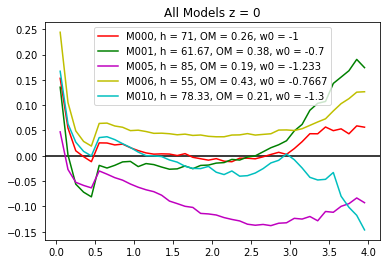

In [56]:
plt.axhline(0, color = 'black')
plt.plot(rad_0[0], median_perc_diff_M0, color = 'r', label = 'M000, h = 71, OM = 0.26, w0 = -1')
plt.plot(rad_0[0], median_perc_diff_M1, color = 'g', label = 'M001, h = 61.67, OM = 0.38, w0 = -0.7')
plt.plot(rad_0[0], median_perc_diff_M5, color = 'm', label = 'M005, h = 85, OM = 0.19, w0 = -1.233')
plt.plot(rad_0[0], median_perc_diff_M6, color = 'y', label = 'M006, h = 55, OM = 0.43, w0 = -0.7667')
plt.plot(rad_0[0], median_perc_diff_M10, color = 'c', label = 'M010, h = 78.33, OM = 0.21, w0 = -1.3')

#plt.xlim(0.4,4)
plt.title('All Models z = 0')
plt.legend()
plt.savefig('z0_comp', dpi = 200)
plt.show()

In [96]:
print(median_perc_diff_M5)


[0.047229858259150145, -0.027090281787556434, -0.05243310729025782, -0.058593896486110374, -0.06345563922092465, -0.0299782240349748, -0.03636076116460883, -0.043262812899965565, -0.04820751013379275, -0.055829168152157674, -0.062185301302275175, -0.06719424808430437, -0.07097645672381543, -0.07793159229598948, -0.089524469119903, -0.09453951173875064, -0.0998640720245335, -0.10208013271376522, -0.11390815851515224, -0.11494261059878372, -0.11706344303308802, -0.12216781557290314, -0.12579847171980343, -0.1287774374390654, -0.13523651046314583, -0.13727348928416994, -0.13574260897519658, -0.1380894297150036, -0.13330951186206838, -0.13245743897125845, -0.12364918739290393, -0.12510147722098858, -0.12000978448581226, -0.1284751422448064, -0.11010884317286576, -0.1116836166692974, -0.09991312907361273, -0.09466984694951963, -0.08338604139002898, -0.09273280594469459, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, nan, inf, inf, inf, inf, inf, nan, nan, inf, in

In [100]:
def filter_inf(ar):
  return ar[np.isfinite(ar)]

mylist = median_perc_diff_M0
mylist = [str(x) for x in mylist]
newlist = [x for x in mylist if x != 'nan']
mpd_M0 = np.asarray(newlist, dtype=np.float64)

mylistM1 = median_perc_diff_M1
mylistM1 = [str(x) for x in mylistM1]
newlistM1 = [x for x in mylistM1 if x != 'nan']
mpd_M1 = np.asarray(newlistM1, dtype=np.float64)

mylistM5 = median_perc_diff_M5
mylistM5 = [str(x) for x in mylistM5]
newlistM5 = [x for x in mylistM5 if x != 'nan']
mpd_M5_2 = np.asarray(newlistM5, dtype=np.float64)
mpd_M5 = filter_inf(mpd_M5_2)

mylistM6 = median_perc_diff_M6
mylistM6 = [str(x) for x in mylistM6]
newlistM6 = [x for x in mylistM6 if x != 'nan']
mpd_M6_2 = np.asarray(newlistM6, dtype=np.float64)
mpd_M6 = filter_inf(mpd_M6_2)

mylistM10 = median_perc_diff_M10
mylistM10 = [str(x) for x in mylistM10]
newlistM10 = [x for x in mylistM10 if x != 'nan']
mpd_M10 = np.asarray(newlistM10, dtype=np.float64)


M0z0_avg = np.mean(mpd_M0)
print (M0z0_avg)
M1z0_avg = np.mean(mpd_M1)
print (M1z0_avg)
M5z0_avg = np.mean(mpd_M5)
print (M5z0_avg)
M6z0_avg = np.mean(mpd_M6)
print (M6z0_avg)
M10z0_avg = np.mean(mpd_M10)
print (M10z0_avg)

0.018558929746487377
0.02256090160121748
-0.09141935319021761
0.061594068670679215
-0.015067423833165231


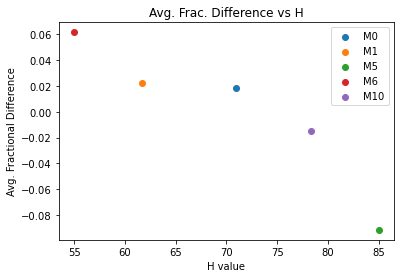

In [109]:
plt.scatter(71, M0z0_avg, label = 'M0')
plt.scatter(61.67, M1z0_avg, label = 'M1')
plt.scatter(85, M5z0_avg, label = 'M5')
plt.scatter(55, M6z0_avg, label = 'M6')
plt.scatter(78.33, M10z0_avg, label = 'M10')
plt.legend()
plt.ylabel('Avg. Fractional Difference')
plt.xlabel('H value')
plt.title('Avg. Frac. Difference vs H')
plt.savefig('fracdiff_H_comp.png', dpi = 200)
plt.show()

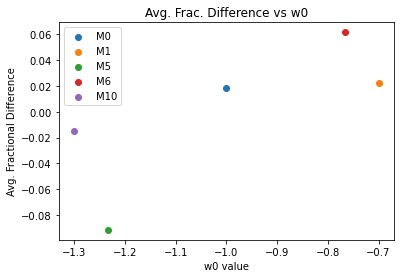

In [110]:
plt.scatter(-1, M0z0_avg, label = 'M0')
plt.scatter(-0.7, M1z0_avg, label = 'M1')
plt.scatter(-1.233, M5z0_avg, label = 'M5')
plt.scatter(-0.7667, M6z0_avg, label = 'M6')
plt.scatter(-1.3, M10z0_avg, label = 'M10')
plt.legend()
plt.title('Avg. Frac. Difference vs w0')
plt.xlabel('w0 value')
plt.ylabel('Avg. Fractional Difference')
plt.savefig('fracdiff_w0_comp.png', dpi = 200)
plt.show()

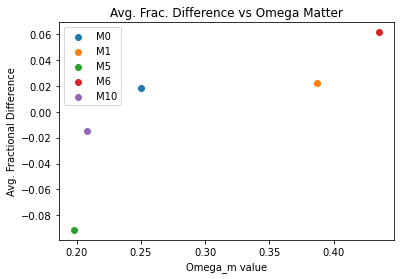

In [111]:
plt.scatter(0.25, M0z0_avg, label = 'M0')
plt.scatter(0.387, M1z0_avg, label = 'M1')
plt.scatter(0.198, M5z0_avg, label = 'M5')
plt.scatter(0.435, M6z0_avg, label = 'M6')
plt.scatter(0.208, M10z0_avg, label = 'M10')
plt.legend()
plt.title('Avg. Frac. Difference vs Omega Matter')
plt.xlabel('Omega_m value')
plt.ylabel('Avg. Fractional Difference')
plt.savefig('fracdiff_OM_comp.png', dpi = 200)
plt.show()

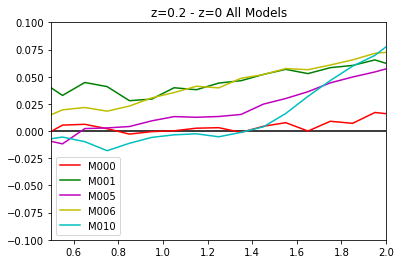

In [44]:
plt.axhline(0, color = 'black')
plt.plot(rad_0[0], M0_z02_z0, color = 'r', label = 'M000')
plt.plot(rad_0[0], M1_z02_z0, color = 'g', label = 'M001')
plt.plot(rad_0[0], M5_z02_z0, color = 'm', label = 'M005')
plt.plot(rad_0[0], M6_z02_z0, color = 'y', label = 'M006')
plt.plot(rad_0[0], M10_z02_z0, color = 'c', label = 'M010')
plt.xlim(0.5,2)
plt.ylim(-0.1, 0.1)
plt.title('z=0.2 - z=0 All Models')
plt.savefig('z02-z0_redshift_differences.png', dpi = 200)
plt.legend()
plt.show()

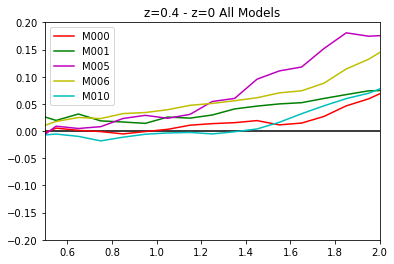

In [45]:
plt.axhline(0, color = 'black')
plt.plot(rad_0[0], M0_z04_z0, color = 'r', label = 'M000')
plt.plot(rad_0[0], M1_z04_z0, color = 'g', label = 'M001')
plt.plot(rad_0[0], M5_z04_z0, color = 'm', label = 'M005')
plt.plot(rad_0[0], M6_z04_z0, color = 'y', label = 'M006')
plt.plot(rad_0[0], M10_z04_z0, color = 'c', label = 'M010')
plt.xlim(0.5,2)
plt.ylim(-0.2, 0.2)
plt.title('z=0.4 - z=0 All Models')
plt.savefig('z04-z0_redshift_differences.png', dpi = 200)
plt.legend()
plt.show()

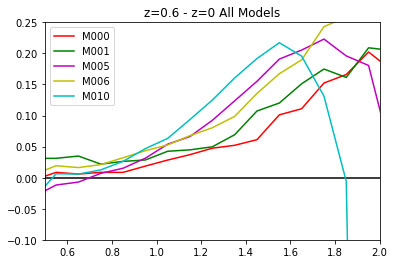

In [46]:
plt.axhline(0, color = 'black')
plt.plot(rad_0[0], M0_z06_z0, color = 'r', label = 'M000')
plt.plot(rad_0[0], M1_z06_z0, color = 'g', label = 'M001')
plt.plot(rad_0[0], M5_z06_z0, color = 'm', label = 'M005')
plt.plot(rad_0[0], M6_z06_z0, color = 'y', label = 'M006')
plt.plot(rad_0[0], M10_z06_z0, color = 'c', label = 'M010')
plt.xlim(0.5,2)
plt.ylim(-0.1, 0.25)
plt.title('z=0.6 - z=0 All Models')
plt.savefig('z06-z0_redshift_differences.png', dpi = 200)
plt.legend()
plt.show()